# ✈️ Singapore Airlines Sentiment Analysis

[![Python](https://img.shields.io/badge/Python-3.8+-blue.svg)](https://www.python.org/downloads/)
[![Jupyter](https://img.shields.io/badge/Jupyter-Notebook-orange.svg)](https://jupyter.org/)

### 📋 Executive Summary

This project evaluates whether star ratings accurately reflect customer sentiment in Singapore Airlines reviews. By comparing lexicon-based models (VADER, TextBlob) with a Zero-Shot Transformer (`facebook/bart-large-mnli`), we aim to uncover hidden insights in "neutral" ratings and generate high-quality sentiment labels.

**Key Findings:**
- **Star Ratings are Noisy:** ~20-25% mismatch between ratings and text sentiment, especially in 3-star reviews.
- **Hidden Negativity:** "Neutral" reviews often contain significant negative feedback.
- **Zero-Shot Superiority:** The transformer model outperformed baseline lexicons, achieving ~88% accuracy on high-confidence samples.

---


In [ ]:
# Environment & Reproducibility
import sys
import transformers
import torch
import nltk

print(f"Python version: {sys.version}")
print(f"Transformers version: {transformers.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"NLTK version: {nltk.__version__}")


# Singapore Airlines Review Sentiment Analysis ✈️📊

**Author:** Vinil Patel

**Goal:** Assess star rating reliability and develop refined sentiment labels using NLP.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import pipeline
from datasets import Dataset

from sklearn.metrics import confusion_matrix, classification_report

import re
from html import unescape

from tqdm import tqdm

import plotly.express as p
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1032)>




---


## 1. Project Scope

### 🎯 Research Questions
- **Q1:** Do star ratings consistently reflect text sentiment?
- **Q2:** Can modern NLP models improve sentiment classification accuracy?
- **Q3:** What is the true nature of "neutral" (3-star) reviews?

### 🔬 Approach
1. **Baseline:** Test VADER & TextBlob against star ratings.
2. **Advanced:** Apply Zero-Shot classification (`facebook/bart-large-mnli`).
3. **Refinement:** Create pseudo-labels using confidence filtering.

### 📊 Dataset
- **Source:** 10,000 Singapore Airlines reviews (Date, Title, Text, Rating).
- **Challenge:** Validating star ratings as reliable sentiment indicators.

---

## 2. Motivation

### 💡 Why This Matters
Star ratings are often biased or ambiguous (e.g., 3-star "neutral" reviews). For airlines, relying solely on ratings risks missing critical feedback hidden in text.

**Objectives:**
1. Quantify rating reliability.
2. Uncover hidden negative feedback.
3. Generate accurate sentiment labels for downstream analysis.

---

In [16]:
#df_labeled= pd.read_csv('/Users/vinilpatel/IDK/Orginise/Data/0.85_labeled__dataset.csv') # Unused placeholder

----

## 2. Data Acquisition & Preprocessing


### 2.1 Data Loading & Inspection

**Preprocessing Steps:**
1. Load raw data
2. Parse dates (convert to datetime)
3. Remove unnecessary columns (`published_platform`, `type`, `helpful_votes`).
4. Rename for clarity



In [ ]:
# Load the dataset
data = pd.read_csv('./Data/singapore_airlines_reviews.csv')

# Date fix
data["published_date"] = pd.to_datetime(data["published_date"], utc=True, errors="coerce")
data["published_date"] = data["published_date"].dt.date

data.drop(columns=["published_platform", 'type', 'helpful_votes'], inplace=True)
data.rename(columns={'published_date': 'Date',
                     'text': 'Review',
                     'title': 'Title',
                     'rating': 'Rating'}, inplace=True)

data = data[['Date', 'Title', 'Review', 'Rating']]
data["word_length"] = data["Review"].apply(len)

### 2.2 Text Cleaning Pipeline

**Challenge:** Raw text contains HTML entities, escaped characters, and formatting artifacts that interfere with sentiment analysis.

**Cleaning Strategy:**
- Remove HTML tags and URLs
- Normalize quotes and apostrophes
- Fix punctuation spacing
- Remove non-ASCII characters (except apostrophes)
- Collapse excessive whitespace

**Implementation:** Custom `clean_review_text()` function, Curate a sophisticated cleaning pipeline for data quality  


In [5]:
def clean_review_text(text):
    text = str(text)
    text = unescape(text)  # Convert HTML entities
    
    # Remove raw noise
    text = re.sub(r'<[^>]+>', '', text)      # HTML tags
    text = re.sub(r'https?://\S+', '', text) # URLs
    text = re.sub(r'\\n|\\r|\\t|\\xa0|\\u200b', ' ', text) # Escaped whitespace
    
    # Normalize apostrophes/quotes
    text = text.replace('’', "'").replace('`', "'")
    
    # Remove non-ASCII but keep apostrophes
    text = re.sub(r"[^\x00-\x7F']", ' ', text)
    
    # Punctuation fixes
    text = re.sub(r'\.{3,}', '…', text)  # ... → …
    text = re.sub(r'[,.!?;:]{2,}', lambda m: m.group(0)[0], text)  # Reduce repeats
    text = re.sub(r'\s+([,.!?;:])', r'\1', text)   # Remove spaces before punctuation
    text = re.sub(r'([,.!?])(?=\w)', r'\1 ', text) # Ensure space after punctuation
    
    # Symbol fixes
    text = re.sub(r'~', '-', text)
    text = re.sub(r'\*([^*]+)\*', r'\1', text)  # remove *emphasis*
    text = text.replace('*', '')
    text = re.sub(r'\{ ?', '[', text)           # { → [
    text = re.sub(r' ?\}', ']', text)           # } → ]
    text = re.sub(r'\s*\|\s*', ' - ', text)     # | → -
    text = re.sub(r"'\s+", "'", text)           # Fix "don 't"
    
    # Final whitespace normalization
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

### 2.3 Feature Engineering

**Created Features:**
1. **Text:** Merged `Title` + `Review` body 
2. **Sentiment (from ratings):** Binned `Rating` into negative/neutral/positive
    
    - (1-2: Negative, 3: Neutral, 4-5: Positive) to serve as a baseline ground truth.

**Assumption:** Star ratings = ground truth (Test this assumption)

**Dataset Shape:** 10,000 reviews × 4 features (Date, Text, Rating, Sentiment)


In [11]:
df = data.copy()
df['Text'] = df['Title'].fillna('') + '. ' + df['Review'].fillna('')
df['Text'] = df['Text'].apply(clean_review_text)

def map_rating_to_sentiment(rating):
    if rating <= 2: return "negative"
    elif rating == 3: return "neutral"
    else: return "positive"

df['Sentiment'] = df['Rating'].apply(map_rating_to_sentiment)

df = df[['Date', 'Text', 'Rating', 'Sentiment']]
df.reset_index(drop=True, inplace=True)

display(df.head(), df['Sentiment'].value_counts())
print(f"Dataset shape: {df.shape}")

,Date,Text,Rating,Sentiment
0,2024-03-12,Ok. We used this airline to go from Singapore ...,3,neutral
1,2024-03-11,The service in Suites Class makes one feel lik...,5,positive
2,2024-03-11,"don't give them your money. Booked, paid and r...",1,negative
3,2024-03-11,Best Airline in the World. Best airline in the...,5,positive
4,2024-03-10,Premium Economy Seating on Singapore Airlines ...,2,negative


Sentiment
positive    7391
negative    1600
neutral     1009
Name: count, dtype: int64

Dataset shape: (10000, 4)


### 2.4 Initial Data Exploration

**Rating Distribution:**
- **Positive (4-5 stars):** ~70% of reviews
- **Negative (1-2 stars):** ~25% of reviews  
- **Neutral (3 stars):** ~5% of reviews

**Review Length Patterns:**
- Longer reviews tend to be negative (more detail in complaints)
- Very short reviews are often extreme (1★ or 5★)

**Hypothesis:** The small "neutral" category may contain hidden sentiment that ratings don't capture.

---

## 3. Baseline Sentiment Analysis

**Objective:** Compare lexicon-based models against star ratings.

**Models:**
1. **VADER (Valence Aware Dictionary and Sentiment Reasoner)**
   - Rule-based, optimized for social media
   - Fast, interpretable
   - Compound score: -1 (very negative) to +1 (very positive)

2. **TextBlob**
   - Pattern-based sentiment analysis
   - Returns polarity: -1 to +1
   - Good for general-purpose text

**Evaluation Metric:** Agreement rate with star rating sentiment bins


### 3.2 Model Application
Applying standard thresholds:
- **Positive:** > 0.05 (VADER) / 0.1 (TextBlob)
- **Negative:** < -0.05 (VADER) / -0.1 (TextBlob)


#### 3.3 Model Application

In [20]:
df['vader_label'] = df['vader_score'].apply(lambda x: 'positive' if x >= 0.05 else('negative' if x <= -0.05 else 'neutral'))
df['textblob_label'] = df['textblob_polarity'].apply(lambda x: 'positive' if x >= 0.1 else('negative' if x <= -0.1 else 'neutral'))

#### 3.4 Performance Evaluation

In [22]:
# Match Rates
mismatches = df[
    (df['vader_label'] != df['Sentiment']) |
    (df['textblob_label'] != df['Sentiment'])
]

print(f'Mismatched reviews: {len(mismatches)} / {len(df)}')

vader_match_rate = (df["vader_label"] == df["Sentiment"]).mean() * 100
textblob_match_rate = (df["textblob_label"] == df["Sentiment"]).mean() * 100

print(f"VADER match rate: {vader_match_rate:.2f}%")
print(f"TextBlob match rate: {textblob_match_rate:.2f}%")

Mismatched reviews: 2772 / 10000
VADER match rate: 82.48%
TextBlob match rate: 78.37%


In [23]:
# Confusion Matrices 
def detailed_confusion_by_rating(df, model_label_column):
    return pd.crosstab(df['Sentiment'], df[model_label_column], normalize='index').round(2)

print(detailed_confusion_by_rating(df, 'vader_label'))
print('\n')
print(detailed_confusion_by_rating(df, 'textblob_label'))

vader_label  negative  neutral  positive
Sentiment                               
negative         0.69     0.01      0.29
neutral          0.40     0.02      0.57
positive         0.03     0.01      0.96


textblob_label  negative  neutral  positive
Sentiment                                  
negative            0.29     0.53      0.19
neutral             0.12     0.44      0.44
positive            0.01     0.06      0.94


Star ratings are not perfect sentiment labels: There is a significant mismatch (17-22%) between the star ratings and the sentiment expressed in the text. This could be due to various factors such as rating inflation, different rating criteria, or the presence of mixed sentiments.

In [24]:
df['vader_is_neutral'] = df['vader_label'] == 'neutral'
df['textblob_is_neutral'] = df['textblob_label'] == 'neutral'

# Group by rating and calculate the percentage of neutral predictions
neutrality_by_rating = df.groupby('Rating').agg({
    'vader_is_neutral': 'mean',
    'textblob_is_neutral': 'mean'
}).round(4) * 100 

neutrality_by_rating.columns = ['% VADER Neutral', '% TextBlob Neutral']
print(neutrality_by_rating)

        % VADER Neutral  % TextBlob Neutral
Rating                                     
1                  1.23               52.22
2                  1.66               53.22
3                  2.38               44.10
4                  1.17               13.17
5                  0.29                2.97


Observing the behaviour of both polarity models, Vader is strict towards 'neutral', only assining label when text is completely devoid of emotional tones (1-3% detected). 
Textblob in comparison, has assigned a much larger portion as neutral. 44-53% are detected in ratings 1-3.


Hypothesis: 
- Textblob algorithm averages the positives and negatives near 0, thus mislabeling polarity. 
- The text is Mixed. Mixed texts have positive and negative words, thus pulling polarity towards zero but not eliminating subjectivity.
- This explains why the 'neutral' reviews (3 star) didn’t behave as True “neutral” in VADER/TextBlob, they actually belong in a mixed/conflict class, not neutral.
- The established threshold/binning for polarity need further adjustments to better caapture the tone within the text.

Therefore concluding that:	
* VADER = strict neutral 
* TextBlob = misclassified mixed

Next:
Statistic test for polarity

#### 3.5 Statistical Validation

In [25]:
from scipy.stats import spearmanr

spearman_corr_vader = spearmanr(df['Rating'], df['vader_score'])
spearman_corr_textblob = spearmanr(df['Rating'], df['textblob_polarity'])

print("Spearman correlation (VADER):", spearman_corr_vader)
print("Spearman correlation (TextBlob):", spearman_corr_textblob)

Spearman correlation (VADER): SignificanceResult(statistic=np.float64(0.5851191193823625), pvalue=np.float64(0.0))
Spearman correlation (TextBlob): SignificanceResult(statistic=np.float64(0.6667704314476962), pvalue=np.float64(0.0))


#### 3.6 Key Findings
Baseline models show a **20-25% mismatch** with star ratings. VADER is strict on neutrality, while TextBlob over-classifies mixed reviews as neutral. This highlights the need for refined thresholds or advanced modeling.


----

## 4. Threshold Optimization & Mixed Sentiment Discovery

### 4.1 Refined Thresholds

**Problem:** Default thresholds may be suboptimal for airline reviews.

**Experiment:** Test expanded thresholds to capture mixed sentiment:

**VADER Refined:**
- Strongly positive: ≥ 0.35
- Mixed positive: 0.05 to 0.35
- Neutral: -0.05 to 0.05
- Mixed negative: -0.35 to -0.05
- Strongly negative: ≤ -0.35

**TextBlob Refined:**
- Positive: > 0.15
- Mixed positive: 0.05 to 0.15
- Neutral: -0.05 to 0.05
- Mixed negative: -0.15 to -0.05
- Negative: < -0.15
* Basic thresholds show significant mismatch, especially for neutral reviews.
* Investigating refined thresholds to better capture mixed sentiment

> **Technical Note:** The thresholds (0.35, -0.35) were selected based on initial experimentation and standard literature recommendations for capturing 'strong' sentiment, as the default VADER thresholds (0.05) often over-classify weak sentiment as positive/negative.


In [26]:
def classify_vader_sentiment(compound_score):
    if compound_score >= 0.35:
        return 'strongly_positive'
    elif compound_score > 0.05:
        return 'mixed_positive'
    elif compound_score >= -0.05:
        return 'neutral'
    elif compound_score >= -0.35:
        return 'mixed_negative'
    else:
        return 'strongly_negative'

def classify_textblob_sentiment(polarity_score):
    if polarity_score > 0.15:
        return 'positive'
    elif polarity_score > 0.05:
        return 'mixed_positive'
    elif polarity_score >= -0.05:
        return 'neutral'
    elif polarity_score >= -0.15:
        return 'mixed_negative'
    else:
        return 'negative'

df['vader_sentiment'] = df['vader_score'].apply(classify_vader_sentiment)
df['textblob_sentiment'] = df['textblob_polarity'].apply(classify_textblob_sentiment)

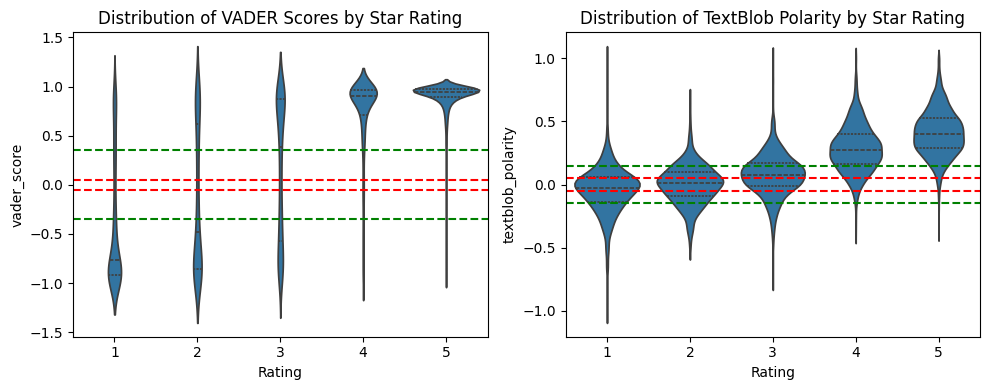

In [29]:
plt.figure(figsize=(10, 4))
# VADER
plt.subplot(1, 2, 1)
sns.violinplot(x='Rating', y='vader_score', data=df, inner="quartile")
plt.title('Distribution of VADER Scores by Star Rating')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.axhline(y=-0.05, color='r', linestyle='--')
plt.axhline(y=0.35, color='g', linestyle='--')
plt.axhline(y=-0.35, color='g', linestyle='--')

# TextBlob
plt.subplot(1, 2, 2)
sns.violinplot(x='Rating', y='textblob_polarity', data=df, inner="quartile")
plt.title('Distribution of TextBlob Polarity by Star Rating')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.axhline(y=-0.05, color='r', linestyle='--')
plt.axhline(y=0.15, color='g', linestyle='--')
plt.axhline(y=-0.15, color='g', linestyle='--')

plt.tight_layout()
plt.show()

TextBlob:
* TextBlob is more generous around neutrality and can blur neutral/mixed together.
* Mixed texts usually have both strong positive and strong negative words, pulling polarity towards zero but not eliminating subjectivity.
* Research confirms ±0.05–0.15 is the most frequent zone where these appear.


- The established threshold/binning for polarity difference is the cause of the differnces in prediction of the models.

In [27]:
display(df['vader_sentiment'].value_counts(), df['textblob_sentiment'].value_counts())

vader_sentiment
strongly_positive    7875
strongly_negative    1482
mixed_positive        290
mixed_negative        268
neutral                85
Name: count, dtype: int64

textblob_sentiment
positive          7090
mixed_positive    1110
neutral            908
mixed_negative     470
negative           422
Name: count, dtype: int64

### 4.2 Threshold Analysis Results 

In [30]:
df['vader_basic'] = df['vader_sentiment'].map({
    'strongly_positive': 'positive',
    'mixed_positive': 'mixed', 
    'neutral': 'neutral',
    'mixed_negative': 'mixed', 
    'strongly_negative': 'negative'
})

df['textblob_basic'] = df['textblob_sentiment'].map({
    'positive': 'positive',
    'mixed_positive': 'mixed',
    'neutral': 'neutral',
    'mixed_negative': 'mixed',
    'negative': 'negative'
})

In [31]:
# AGREEMENT WITH ORIGINAL RATING LABELS (FOR REFERENCE)
mismatches = df[
    (df['vader_basic'] != df['Sentiment']) |
    (df['textblob_basic'] != df['Sentiment'])
]

print(f'Mismatched reviews: {len(mismatches)} / {len(df)}')
vader_agreement = (df['vader_basic'] == df['Sentiment']).mean() * 100
textblob_agreement = (df['textblob_basic'] == df['Sentiment']).mean() * 100

print(f"VADER agreement with original labels: {vader_agreement:.2f}%")
print(f"TextBlob agreement with original labels: {textblob_agreement:.2f}%")

Mismatched reviews: 3260 / 10000
VADER agreement with original labels: 80.20%
TextBlob agreement with original labels: 71.69%


In [32]:
print("VADER SENTIMENT vs RATING-BASED SENTIMENT")
print("------"*6)
vader_crosstab = pd.crosstab(df['Sentiment'], df['vader_basic'], normalize='index') * 100
print(vader_crosstab.round(2))
print("\n")

print("TEXTBLOB SENTIMENT vs RATING-BASED SENTIMENT")
print("------"*6)
textblob_crosstab = pd.crosstab(df['Sentiment'], df['textblob_basic'], normalize='index') * 100
print(textblob_crosstab.round(2))


VADER SENTIMENT vs RATING-BASED SENTIMENT
------------------------------------
vader_basic  mixed  negative  neutral  positive
Sentiment                                      
negative     12.38     62.81     1.38     23.44
neutral      14.87     32.31     2.38     50.45
positive      2.84      2.04     0.53     94.59


TEXTBLOB SENTIMENT vs RATING-BASED SENTIMENT
------------------------------------
textblob_basic  mixed  negative  neutral  positive
Sentiment                                         
negative        37.94     20.19    30.31     11.56
neutral         38.06      8.13    23.98     29.83
positive         7.97      0.23     2.45     89.35


In [33]:
# 2. Focused Analysis: What happened to the "neutral" (3-star) reviews?
print("FOCUSED ANALYSIS: 3-STAR ('NEUTRAL') REVIEWS")
print("------"*6)
three_star_reviews = df[df['Sentiment'] == 'neutral']

print("VADER classification of 3-star reviews:")
print(three_star_reviews['vader_basic'].value_counts(normalize=True).round(4) * 100)
print("\n")

print("TextBlob classification of 3-star reviews:")
print(three_star_reviews['textblob_basic'].value_counts(normalize=True).round(4) * 100)

FOCUSED ANALYSIS: 3-STAR ('NEUTRAL') REVIEWS
------------------------------------
VADER classification of 3-star reviews:
vader_basic
positive    50.45
negative    32.31
mixed       14.87
neutral      2.38
Name: proportion, dtype: float64


TextBlob classification of 3-star reviews:
textblob_basic
mixed       38.06
positive    29.83
neutral     23.98
negative     8.13
Name: proportion, dtype: float64


#### Model-Specific Observations
- **VADER**  
  - Positive class: strong performance (96.3% correct).  
  - Negative class: moderate (69.2% correct).  
  - Neutral class: very poor (2.4% correct).  

- **TextBlob**  
  - Positive class: strong performance (93.8% correct).  
  - Negative class: weak (28.7% correct, 71.3% mismatch).  
  - Neutral class: better than VADER (44.1% correct), but still limited.  

In [34]:
# 4. Detailed distribution of the new MIXED category
print("DETAILED ANALYSIS OF MIXED SENTIMENT REVIEWS")
print("======"*6)
print("Mixed sentiment distribution across star ratings (VADER):")
mixed_by_rating_vader = df[df['vader_basic'] == 'mixed'].groupby('Rating').size()
mixed_pct_vader = mixed_by_rating_vader / mixed_by_rating_vader.sum() * 100
print(mixed_pct_vader.round(2))
print("\n")

print("Mixed sentiment distribution across star ratings (TextBlob):")
mixed_by_rating_textblob = df[df['textblob_basic'] == 'mixed'].groupby('Rating').size()
mixed_pct_textblob = mixed_by_rating_textblob / mixed_by_rating_textblob.sum() * 100
print(mixed_pct_textblob.round(2))

DETAILED ANALYSIS OF MIXED SENTIMENT REVIEWS
Mixed sentiment distribution across star ratings (VADER):
Rating
1    22.94
2    12.54
3    26.88
4    20.43
5    17.20
dtype: float64


Mixed sentiment distribution across star ratings (TextBlob):
Rating
1    24.56
2    13.86
3    24.30
4    20.63
5    16.65
dtype: float64


### 4.3 Mixed Sentiment Category Validation
We see that the vader 'neutral' class amongst each rating is the same as the previous threshold, this further confirms the inefficient neutral tone in the text.

- Reveals that 'Rating' is not a perfect ground truth and may not fully capture text sentiment.
- Causes include:
  - Reviewer bias
  - Ratings not reflecting true sentiment

### Findings Summary
- **Agreement:** ~75-80% alignment with ratings.
- **Mismatch:** ~20-25% of reviews (especially neutral ones) don't match the rating.
- **Conclusion:** Star ratings are a noisy label. We need a context-aware model (Zero-Shot) to resolve these ambiguities.

---

#### Verdict & Limitations
- Ratings act as a noisy gauge for sentiment, with high mismatches for neutral reviews.  
- Both VADER and TextBlob have limitaions:  
  - VADER is optimized for short, informal text (e.g., tweets).  
  - TextBlob is older, lexicon-based, and lacks contextual depth.  

#### Next Steps
To overcome these limitations, we will explore **transformer-based approaches**, starting with a zero-shot model trained on large, diverse datasets. This too provide a more reliable sentiment predictions without depending solely on noisy star ratings.  

---

## 5. Advanced Sentiment Classification (Zero-Shot)

**Why Zero-Shot?**
Lexicon models lack context. We use `facebook/bart-large-mnli`, a transformer model trained on Natural Language Inference, to understand nuance without domain-specific training.


### 5.4 Zero-Shot Predictions

In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)
candidate_labels = ['positive', 'negative', 'neutral']

def get_zero_shot_sentiment(examples):
    """Applies zero-shot classification to a batch of reviews and returns the top sentiment labels and scores."""
    reviews = [review if pd.notna(review) else "" for review in examples['Text']] 
    results = classifier(reviews, candidate_labels)
    top_labels = [result['labels'][0] for result in results]
    top_scores = [result['scores'][0] for result in results]
    return {'zero_shot_sentiment': top_labels, 'zero_shot_confidence': top_scores}

dataset = Dataset.from_pandas(df)
dataset = dataset.map(get_zero_shot_sentiment, batched=True, batch_size=32) 

data_with_sentiment = dataset.to_pandas()

In [35]:
display(df['zero_shot_sentiment'].value_counts())
df.groupby('zero_shot_sentiment')['zero_shot_confidence'].mean()

zero_shot_sentiment
positive    6862
negative    3102
neutral       36
Name: count, dtype: int64

zero_shot_sentiment
negative    0.891809
neutral     0.551430
positive    0.930676
Name: zero_shot_confidence, dtype: float64

In [37]:
df.groupby('zero_shot_sentiment')['zero_shot_confidence'].mean()

zero_shot_sentiment
negative    0.891809
neutral     0.551430
positive    0.930676
Name: zero_shot_confidence, dtype: float64

### 5.5 Performance Evaluation

#### 5.5.1 Comparison with Star Ratings

In [38]:
def mismatch_by_rating(data, sentiment_col):
    return (
        data.groupby("Sentiment")
          .apply(lambda x: 100 - (x[sentiment_col] == x["Sentiment"]).mean() * 100)
          .round(2)
    )

# Match rate against star ratings
zeroshot_match_rate = (df["zero_shot_sentiment"] == df["Sentiment"]).mean() * 100
print(f"Zero-Shot match rate: {zeroshot_match_rate:.2f}%")

# Mismatch percentages
zeroshot_mismatch_by_rating = mismatch_by_rating(df, 'zero_shot_sentiment')
print("\nZero-Shot Mismatch (%):")
print(zeroshot_mismatch_by_rating)

Zero-Shot match rate: 83.20%

Zero-Shot Mismatch (%):
Sentiment
negative     1.12
neutral     99.01
positive     8.97
dtype: float64


In [39]:
# Detailed confusion
print(detailed_confusion_by_rating(df, 'zero_shot_sentiment'))

zero_shot_sentiment  negative  neutral  positive
Sentiment                                       
negative                 0.99     0.00      0.01
neutral                  0.87     0.01      0.12
positive                 0.09     0.00      0.91


**Insight:** Zero-Shot predictions align well with clear positive/negative ratings but reveal that many "neutral" ratings are actually negative.


#### 5.5.2 Comparison with Baseline Models


In [40]:
# Extract reviews where polarity models mismatch with zero-shot
mismatches = df[
    (df["vader_label"] != df["zero_shot_sentiment"]) |
    (df["textblob_label"] != df["zero_shot_sentiment"])
]

print(f"Mismatched reviews zeroshot: {len(mismatches)} / {len(df)}")
vader_zs_match_rate = (df["vader_label"] == df["zero_shot_sentiment"]).mean() * 100
textblob_zs_match_rate = (df["textblob_label"] == df["zero_shot_sentiment"]).mean() * 100

print(f"VADER vs Zero-Shot: {vader_zs_match_rate:.2f}% match")
print(f"TextBlob vs Zero-Shot: {textblob_zs_match_rate:.2f}% match")

Mismatched reviews zeroshot: 2935 / 10000
VADER vs Zero-Shot: 83.88% match
TextBlob vs Zero-Shot: 72.19% match


### 5.6 Confidence Analysis


### 5.7 Pseudo-Labeling Strategy

In [41]:
high_conf = df[df['zero_shot_confidence'] > 0.85].copy()
low_conf = df[df['zero_shot_confidence'] <= 0.85].copy()

print(f'Num High_Conf: {high_conf.shape[0]}')
print(f'Num Low_Conf: {low_conf.shape[0]}') 
print(f'Total: {len(df)}')

Num High_Conf: 8484
Num Low_Conf: 1516
Total: 10000


Shape for each Confidence Score:

    Num sample out of 10,000
            (High, Low)
    0.95 - (6314, 3686)
    0.90 - (7920, 2080)
    0.85 - (8484, 1516)
    0.80 - (8812, 1188)

-  As the confidence scored increases the number of samples filtered decline from total 10K.

In [42]:
# Sentiment(rating) Match Percentage
vader_match_rate = (high_conf["vader_label"] == high_conf["Sentiment"]).mean() * 100
textblob_match_rate = (high_conf["textblob_label"] == high_conf["Sentiment"]).mean() * 100
zeroshot_match_rate = (high_conf["zero_shot_sentiment"] == high_conf["Sentiment"]).mean() * 100

print(f"VADER match rate: {vader_match_rate:.2f}%")
print(f"TextBlob match rate: {textblob_match_rate:.2f}%")
print(f"Zero-Shot match rate: {zeroshot_match_rate:.2f}%")

VADER match rate: 84.87%
TextBlob match rate: 80.15%
Zero-Shot match rate: 88.60%


In [43]:
high_conf.value_counts(subset=['zero_shot_sentiment']), low_conf.value_counts(subset=['zero_shot_sentiment'])

(zero_shot_sentiment
 positive               6070
 negative               2412
 neutral                   2
 Name: count, dtype: int64,
 zero_shot_sentiment
 positive               792
 negative               690
 neutral                 34
 Name: count, dtype: int64)

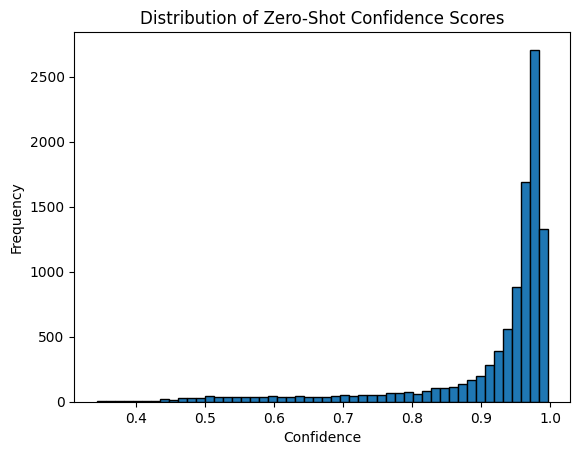

In [44]:
plt.hist(df['zero_shot_confidence'], bins=50, edgecolor='black')
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Distribution of Zero-Shot Confidence Scores")
plt.show()

Threshold 0.50: keeps 98.49% of data
Threshold 0.55: keeps 97.03% of data
Threshold 0.60: keeps 95.57% of data
Threshold 0.65: keeps 94.14% of data
Threshold 0.70: keeps 92.57% of data
Threshold 0.75: keeps 90.63% of data
Threshold 0.80: keeps 88.12% of data
Threshold 0.85: keeps 84.84% of data
Threshold 0.90: keeps 79.20% of data
Threshold 0.95: keeps 63.14% of data


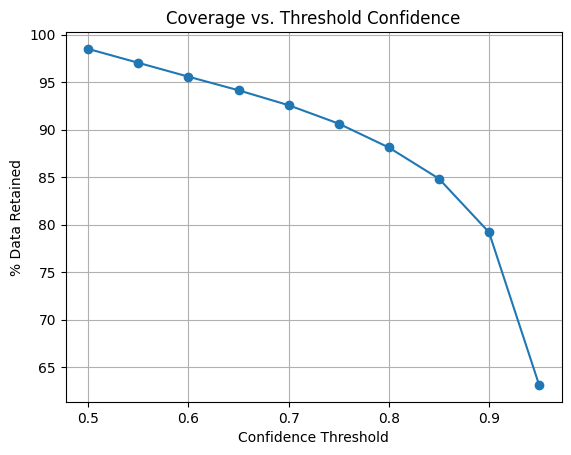

In [45]:
thresholds = np.arange(0.5, 1, 0.05)
coverage = [(df['zero_shot_confidence'] >= t).mean() * 100 for t in thresholds]

for t, c in zip(thresholds, coverage):
    print(f"Threshold {t:.2f}: keeps {c:.2f}% of data")

plt.plot(thresholds, coverage, marker='o')
plt.title("Coverage vs. Threshold Confidence")
plt.xlabel("Confidence Threshold")
plt.ylabel("% Data Retained")
plt.grid(True)
plt.show()

### 5.8 Final Label Generation
We create a `final_sentiment` label by trusting High-Confidence (>0.85) Zero-Shot predictions. Low-confidence or "neutral" predictions are categorized as **Mixed Sentiment**.


In [46]:
def final_label(row):
    if row['zero_shot_confidence'] < 0.85:
        return 'mixed sentiment'
    elif row['zero_shot_sentiment'] == 'neutral':
        return 'mixed sentiment'
    else:
        return row['zero_shot_sentiment']

df['final_sentiment1'] = df.apply(final_label, axis=1)
df['final_sentiment1'].value_counts(), df.shape

(final_sentiment1
 positive           6070
 negative           2412
 mixed sentiment    1518
 Name: count, dtype: int64,
 (10000, 18))

In [47]:
def detailed_confusion_by_rating(df, model_label_column):
    return pd.crosstab(df['Sentiment'], df[model_label_column], normalize='index').round(2)


print(detailed_confusion_by_rating(df, 'final_sentiment1'))

final_sentiment1  mixed sentiment  negative  positive
Sentiment                                            
negative                     0.06      0.94      0.00
neutral                      0.30      0.65      0.05
positive                     0.15      0.03      0.81


In [48]:
def alignment_counts(df, label):
    return pd.crosstab(df['Rating'], df[label], normalize='index')*100   

al_zero = alignment_counts(df, 'final_sentiment1')
print(al_zero.round(2))

final_sentiment1  mixed sentiment  negative  positive
Rating                                               
1                            3.60     96.12      0.28
2                           10.13     88.95      0.92
3                           30.43     65.01      4.56
4                           34.67     11.03     54.30
5                            8.04      0.74     91.22


Text(0.5, 1.0, 'VADER Classification of 3-Star Reviews')

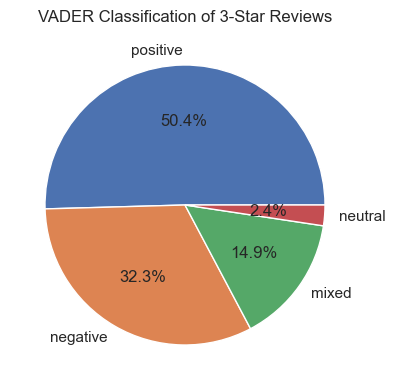

In [49]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 3)
three_star_vader = three_star_reviews['vader_basic'].value_counts()
plt.pie(three_star_vader.values, labels=three_star_vader.index, autopct='%1.1f%%')
plt.title('VADER Classification of 3-Star Reviews')


#### ONLY reviews where Zero-Shot model is confident (confidence > 0.85). isolating trustworthy Zero-Shot predictions to:
- Measure how well each model aligns with ground-truth sentiment from 'ratings'
- Reveal performance gaps across sentiment classes (positive, negative, neutral)

 **Key Insights:**
- Zero-Shot excels in detecting negative sentiment
- VADER/TextBlob perform best on clearly positive sentiment
- Neutral sentiment shows high mismatch across all models, supporting the move to a "mixed" label

### 5.9 Summary
The Zero-Shot model confirmed the negativity in many 3-star reviews. By applying a confidence threshold (0.85) and grouping uncertain/neutral predictions into 'mixed sentiment', we created the final_sentiment column, offering a more text-accurate reflection of sentiment than the original ratings.

Data Quality Process:
1. Raw Text (Unstructured)
    
2. Star Ratings (Weak Structure, Noisy Labels)  
    
3. Lexicon Model Predictions (Structured, Limited Nuance)
    
4. Transformer Pseudo-Labels (Semi-Structured, High Reliability)
    
5. Confidence-Filtered Training Set (Optimized Structure)


---


## 6. Conclusions & Future Directions

### Key Takeaways
1. **Ratings ≠ Sentiment:** ~25% mismatch proves ratings are unreliable ground truth.
2. **Hidden Negativity:** Most 3-star reviews are negative or mixed, not neutral.
3. **Model Success:** Zero-Shot classification (88% match) provides a superior, context-aware signal compared to lexicons.

### Future Steps
- **Fine-tuning:** Train a BERT models on our high-confidence pseudo-labels.
- **Topic Senitment Analysis:** Extract specific pain points (e.g., "food", "service").
- **Temporal Trends:** Correlate sentiment shifts with operational changes.
